In [2]:
# ================================================================
# 1. IMPORT LIBRARIES
# ================================================================
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Plotting (optional)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [3]:


# Path to your CSV folder
data_path = r"C:\Desktop\nsl_kdd_dataset\data"

# List of your CSV files
csv_files = [
    "Backdoor_Malware.csv",
    "BenignTraffic.csv",
    "DDoS-ACK_Fragmentation.csv",
    "DNS_Spoofing.csv",
    "DoS-HTTP_Flood.csv"
]

# Try loading each file
dataframes = []

for file in csv_files:
    file_path = os.path.join(data_path, file)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        print(f"Loaded: {file} → Shape: {df.shape}")
        df["source_file"] = file
        dataframes.append(df)
    else:
        print(f" File NOT found: {file_path}")

Loaded: Backdoor_Malware.csv → Shape: (33349, 135)
Loaded: BenignTraffic.csv → Shape: (297063, 135)


C:\Users\AT\AppData\Local\Temp\ipykernel_10100\600864262.py:20: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Loaded: DDoS-ACK_Fragmentation.csv → Shape: (291481, 135)


C:\Users\AT\AppData\Local\Temp\ipykernel_10100\600864262.py:20: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Loaded: DNS_Spoofing.csv → Shape: (296025, 135)
Loaded: DoS-HTTP_Flood.csv → Shape: (156328, 135)


In [4]:
# ========================================================
# STEP 2 — MERGE CSVs
# ========================================================

# Merge all dataframes into one large DataFrame
full_df = pd.concat(dataframes, ignore_index=True)

print("Merged dataset shape:", full_df.shape)

Merged dataset shape: (1074246, 136)


In [5]:
# ========================================================
# CREATE BINARY LABEL
# (Benign = 0, Attack = 1)
# ========================================================

full_df["label"] = full_df["source_file"].apply(
    lambda x: 0 if "Benign" in x else 1
)

print("\nLabel distribution:")
print(full_df["label"].value_counts())


Label distribution:
label
1    777183
0    297063
Name: count, dtype: int64


In [6]:
# ========================================================
# BASIC AUDIT
# ========================================================

print("\nFirst 5 rows:")
display(full_df.head())

print("\nMissing values per column:")
print(full_df.isnull().sum().head())


First 5 rows:


,stream,src_mac,dst_mac,src_ip,dst_ip,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,...,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count,source_file,label
0,0,3c:18:a0:41:c3:a0,Wyze Camera,52.32.107.17,192.168.137.179,443,48531,0.000000,0.000000,2,...,12.0,12.0,12.0,0.0,12.0,12.0,0.0,1.0,Backdoor_Malware.csv,1
1,-1,dc:a6:32:dc:27:d5,Philips Hue Bridge,NaN,NaN,0,0,0.102862,0.102862,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Backdoor_Malware.csv,1
2,-1,00:a3:d1:07:6f:03,00:a3:d1:07:6f:03,NaN,NaN,0,0,0.187258,0.084396,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Backdoor_Malware.csv,1
3,1,3c:18:a0:41:c3:a0,Nest Indoor Camera,35.185.44.250,192.168.137.34,443,54482,0.189870,0.002612,3,...,12.0,12.0,12.0,0.0,12.0,12.0,0.0,1.0,Backdoor_Malware.csv,1
4,-1,00:a3:d1:07:6f:03,01:80:c2:00:00:00,NaN,NaN,0,0,0.396113,0.206243,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Backdoor_Malware.csv,1



Missing values per column:
stream         0
src_mac        0
dst_mac        0
src_ip     48107
dst_ip     48107
dtype: int64


In [7]:
#  — IDENTIFY COLUMN TYPES
# ========================================================

# Exclude helper columns
ignore_cols = ["source_file", "label"]

# Detect categorical columns (dtype = object or string-like)
categorical_cols = [
    col for col in full_df.columns
    if full_df[col].dtype == "object" and col not in ignore_cols
]

In [8]:
# Detect numeric columns (int, float)
numeric_cols = [
    col for col in full_df.columns
    if full_df[col].dtype != "object" and col not in ignore_cols
]

print("Number of categorical columns:", len(categorical_cols))
print("Categorical columns:", categorical_cols[:20], "...")

print("\nNumber of numeric columns:", len(numeric_cols))
print("Numeric columns:", numeric_cols[:20], "...")

Number of categorical columns: 16
Categorical columns: ['src_mac', 'dst_mac', 'src_ip', 'dst_ip', 'handshake_version', 'tls_server', 'http_request_method', 'http_host', 'user_agent', 'dns_server', 'device_mac', 'eth_src_oui', 'eth_dst_oui', 'highest_layer', 'http_uri', 'http_content_type'] ...

Number of numeric columns: 119
Numeric columns: ['stream', 'src_port', 'dst_port', 'inter_arrival_time', 'time_since_previously_displayed_frame', 'port_class_dst', 'l4_tcp', 'l4_udp', 'ttl', 'eth_size', 'tcp_window_size', 'payload_entropy', 'handshake_cipher_suites_length', 'handshake_ciphersuites', 'handshake_extensions_length', 'handshake_sig_hash_alg_len', 'http_response_code', 'dns_query_type', 'dns_len_qry', 'dns_interval'] ...


In [9]:
# ========================================================
# STEP 4 — HANDLE MISSING VALUES (SAFE VERSION)
# ========================================================

# Numeric columns: fill missing with median
for col in numeric_cols:
    median_val = full_df[col].median()
    full_df[col] = full_df[col].fillna(median_val)

# Categorical columns: fill missing with 'unknown'
for col in categorical_cols:
    full_df[col] = full_df[col].fillna("unknown")

print("Total missing values after processing:",
      full_df.isnull().sum().sum())

Total missing values after processing: 0


In [10]:
print("Missing values after processing:")
print(full_df.isnull().sum().sum(), " total missing values remaining")

Missing values after processing:
0  total missing values remaining


In [11]:
# ========================================================
# — ONE-HOT ENCODE CATEGORICAL FEATURES
# ========================================================

# Make a copy of the cleaned dataset
df_encoded = full_df.copy()

# Convert categorical columns to string (to avoid mixed type errors)
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype(str)

In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

print("Label encoding complete.")

Label encoding complete.


MinMax Scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler

# List of feature columns (exclude label and source_file)
feature_cols = [c for c in df_encoded.columns if c not in [
    "label", "source_file"]]

In [14]:
# Initialize scaler
scaler = MinMaxScaler()

In [15]:
# Fit and transform features
df_encoded[feature_cols] = scaler.fit_transform(df_encoded[feature_cols])

print("Feature scaling complete.")
print("Scaled feature sample (first 5 rows):")
display(df_encoded[feature_cols].head())

Feature scaling complete.
Scaled feature sample (first 5 rows):


,stream,src_mac,dst_mac,src_ip,dst_ip,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,...,sum_p,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count
0,0.000009,0.0375,0.790476,0.764934,0.277946,0.00676,0.740581,0.000000,3.205196e-10,0.666667,...,0.002933,0.004127,0.000345,0.00274,0.002933,0.0,0.002068,0.004009,0.0,0.0
1,0.000000,0.9250,0.666667,1.000000,1.000000,0.00000,0.000000,0.000008,3.296961e-05,0.666667,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0
2,0.000000,0.0000,0.000000,1.000000,1.000000,0.00000,0.000000,0.000014,2.705090e-05,0.666667,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0
3,0.000017,0.0375,0.638095,0.584174,0.330060,0.00676,0.831393,0.000014,8.375178e-07,1.000000,...,0.002933,0.004127,0.000345,0.00274,0.002933,0.0,0.002068,0.004009,0.0,0.0
4,0.000000,0.0000,0.085714,1.000000,1.000000,0.00000,0.000000,0.000030,6.610525e-05,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0


In [16]:
sequence_length = 30

# Features and labels
X_features = df_encoded.drop(columns=["label", "source_file"]).values
y_labels = df_encoded["label"].values

num_rows, num_features = X_features.shape
num_sequences = num_rows // sequence_length  # floor division

In [17]:
# Initialize arrays
X_seq = np.zeros((num_sequences, sequence_length,
                 num_features), dtype=np.float32)
y_seq = np.zeros((num_sequences,), dtype=np.int32)

for i in range(num_sequences):
    start_idx = i * sequence_length
    end_idx = start_idx + sequence_length
    X_seq[i] = X_features[start_idx:end_idx]
    y_seq[i] = 1 if np.any(y_labels[start_idx:end_idx] == 1) else 0

print("Sequences constructed:")
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)
print("Sample sequence labels distribution:", np.bincount(y_seq))

Sequences constructed:
X_seq shape: (35808, 30, 135)
y_seq shape: (35808,)
Sample sequence labels distribution: [ 9901 25907]


In [18]:
# Flatten sequences for CSV storage (30 timesteps × 135 features → 1 row per timestep)
# We'll include label for each timestep sequence
import pandas as pd

# Flatten sequence array for saving
X_flat = X_seq.reshape(-1, X_seq.shape[2])
y_flat = np.repeat(y_seq, sequence_length)

df_flat = pd.DataFrame(
    X_flat, columns=[f"f{i}" for i in range(X_flat.shape[1])])
df_flat["label"] = y_flat

# Save CSV
output_path = r"C:\Desktop\nsl_kdd_dataset\results\nsl_kdd_eval.csv"
df_flat.to_csv(output_path, index=False)
print(f"Preprocessed test set saved to: {output_path}")

Preprocessed test set saved to: C:\Desktop\nsl_kdd_dataset\results\nsl_kdd_eval.csv


In [19]:
import json

# List of feature column names (after preprocessing / scaling)
feature_list = [f"f{i}" for i in range(X_seq.shape[2])]

# Save to JSON
feature_list_path = r"C:\Desktop\nsl_kdd_dataset\results\feature_list.json"
with open(feature_list_path, "w") as f:
    json.dump(feature_list, f)

print(f"Feature list saved to: {feature_list_path}")

Feature list saved to: C:\Desktop\nsl_kdd_dataset\results\feature_list.json


CTM-LSTM


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (30, 135)

inputs = Input(shape=input_shape)

# Temporal Convolution Module
x = Conv1D(filters=64, kernel_size=3,
           padding="same", activation="relu")(inputs)
x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(x)

# LSTM
x = LSTM(128, return_sequences=False)(x)
x = Dropout(0.3)(x)

# Output
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 135)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 30, 64)         │        25,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,281 (536.25 KB)

 Trainable params: 137,281 (536.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

# Early stopping callback
early_stop = EarlyStopping(
    monitor="val_auc", patience=5, mode="max", restore_best_weights=True)

In [22]:
# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=128,
    callbacks=[early_stop]
)

# Save trained model
model.save(r"C:\Desktop\nsl_kdd_dataset\results\lstm_full_final.keras")
print("Model saved: lstm_full_final.keras")

Epoch 1/12
224/224 ━━━━━━━━━━━━━━━━━━━━ 56s 135ms/step - accuracy: 0.9413 - auc: 0.9853 - loss: 0.1359 - val_accuracy: 0.9856 - val_auc: 0.9984 - val_loss: 0.0397
Epoch 2/12
224/224 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - accuracy: 0.9887 - auc: 0.9986 - loss: 0.0340 - val_accuracy: 0.9916 - val_auc: 0.9994 - val_loss: 0.0221
Epoch 3/12
224/224 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - accuracy: 0.9901 - auc: 0.9990 - loss: 0.0289 - val_accuracy: 0.9943 - val_auc: 0.9997 - val_loss: 0.0173
Epoch 4/12
224/224 ━━━━━━━━━━━━━━━━━━━━ 29s 128ms/step - accuracy: 0.9933 - auc: 0.9994 - loss: 0.0196 - val_accuracy: 0.9820 - val_auc: 0.9998 - val_loss: 0.0397
Epoch 5/12
224/224 ━━━━━━━━━━━━━━━━━━━━ 40s 122ms/step - accuracy: 0.9944 - auc: 0.9995 - loss: 0.0168 - val_accuracy: 0.9975 - val_auc: 0.9999 - val_loss: 0.0086
Epoch 6/12
224/224 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.9964 - auc: 0.9997 - loss: 0.0111 - val_accuracy: 0.9962 - val_auc: 0.9999 - val_loss: 0.0096
Epoch 7/12
224/224 ━━━

Model Evaluation & Save Metrics

In [23]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import json

# Predict on validation set
y_pred_prob = model.predict(X_val, batch_size=128)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

# Compute metrics
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Save metrics to JSON
metrics = {"accuracy": accuracy, "f1_score": f1, "roc_auc": roc_auc}
metrics_path = r"C:\Desktop\nsl_kdd_dataset\results\nsl_eval.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f)

print(f"Metrics saved to: {metrics_path}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step
Evaluation Metrics:
Accuracy: 0.9990
F1-score: 0.9993
ROC-AUC: 1.0000
Metrics saved to: C:\Desktop\nsl_kdd_dataset\results\nsl_eval.json


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step


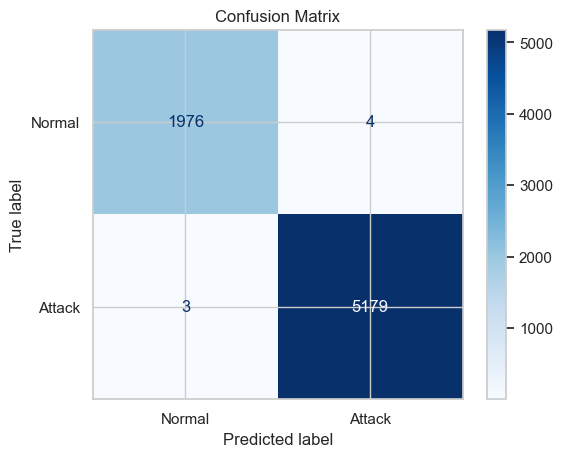

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Predict probabilities
y_pred_prob = model.predict(X_val, batch_size=128)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

# --- Confusion Matrix ---
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Normal", "Attack"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

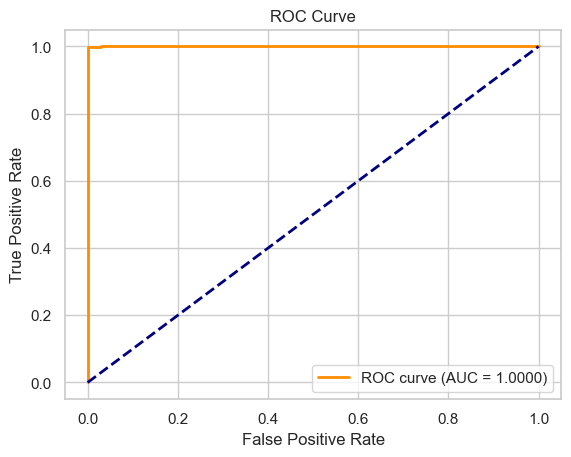

In [25]:

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()